In [1]:
import torch
import random
import numpy as np
import torchvision
from torch import nn
from torch.nn import init
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## 1 生成数据集并展示

In [2]:
train_dataset = torchvision.datasets.MNIST(root='~/Datasets/MNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='~/Datasets/MNIST', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
print(len(train_dataset), len(test_dataset), test_dataset[0][0].shape)

60000 10000 torch.Size([1, 28, 28])


In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

In [5]:
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

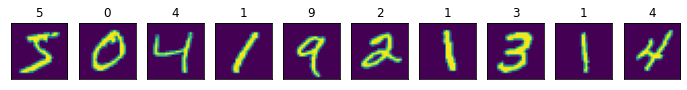

In [6]:
X, y = [], []
for i in range(10):
    X.append(train_dataset[i][0])
    y.append(train_dataset[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 2 读取数据

In [7]:
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
for X, y in train_iter:
    print(X.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


## 3 定义模型

In [9]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2, num_hiddens3 = 784, 10, 10, 10, 10

class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Linear(num_hiddens2, num_hiddens3),
    nn.ReLU(),
    #nn.Sigmoid(),
    #nn.Tanh(),
    #nn.LeakyReLU(),
    #nn.ELU(),
    nn.Linear(num_hiddens3, num_outputs)
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

## 4 定义损失函数

In [10]:
loss = torch.nn.CrossEntropyLoss()

## 5 定义优化算法

In [11]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0003)

## 6 精确度计算函数

In [12]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        test_l_sum += loss(net(X), y).sum()
        n += y.shape[0]
    return acc_sum / n, test_l_sum / n

## 7 定义loss画图函数

In [13]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

## 8 训练模型

In [14]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播 + 更新优化参数
            l.backward()
            if optimizer == None:
                SGD(params, lr)
            else:
                optimizer.step()
        
        train_acc, train_l = evaluate_accuracy(train_iter, net, loss)
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_ls.append(train_l)
        test_ls.append(test_l)
        print('epoch %d, train_loss %.4f, test_loss %.4f, train_acc %.3f, test_acc %.3f' % (epoch + 1, train_ls[-1], test_ls[-1], train_acc, test_acc))
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    return train_ls, test_ls

In [15]:
num_epochs = 20
train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, 32, None, None, optimizer)

epoch 1, train_loss 0.0719, test_loss 0.0721, train_acc 0.112, test_acc 0.114
epoch 2, train_loss 0.0719, test_loss 0.0721, train_acc 0.112, test_acc 0.114
epoch 3, train_loss 0.0719, test_loss 0.0720, train_acc 0.112, test_acc 0.114
epoch 4, train_loss 0.0719, test_loss 0.0720, train_acc 0.112, test_acc 0.114


KeyboardInterrupt: 

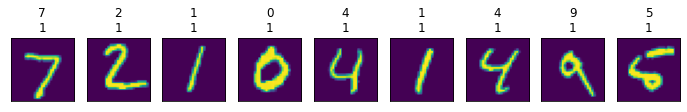

In [31]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])